# SAE Analysis Exploration

This notebook explores Sparse Autoencoder (SAE) analysis for the PVA-SAE project.
We'll analyze how language models internally represent code correctness using GemmaScope SAEs.

## Methodology Overview
1. Load generated dataset (correct vs incorrect solutions) 
2. Extract model activations using GemmaScope SAEs for **Gemma 2 2B**
3. Compute separation scores for latent dimensions
4. Filter out general language patterns (>2% activation on Pile dataset)
5. Identify distinguishing latent directions for code correctness

**Note**: This implementation uses **Gemma 2 2B** model for testing on MPS device with 10 MBPP problems.

## Setup and Imports

In [118]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
from typing import Dict, List, Tuple, Optional
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set up device early
DEVICE = "mps" if torch.backends.mps.is_available() else "cpu"

# Set up plotting
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

print("📚 Imports completed successfully!")
print(f"🔧 PyTorch version: {torch.__version__}")
print(f"🐼 Pandas version: {pd.__version__}")
print(f"🔧 Device: {DEVICE}")

📚 Imports completed successfully!
🔧 PyTorch version: 2.7.0
🐼 Pandas version: 2.2.3
🔧 Device: mps


## Load Generated Dataset

Load the dataset generated from Phase 1 (code generation and testing)

In [119]:
# Find the latest dataset file
data_dir = Path("../data/datasets")  # Updated path from notebook location
dataset_files = list(data_dir.glob("dataset_*.parquet"))

if dataset_files:
    # Get the most recent dataset
    latest_dataset = max(dataset_files, key=lambda x: x.stat().st_mtime)
    print(f"📊 Loading dataset: {latest_dataset.name}")
    
    # Load dataset
    df = pd.read_parquet(latest_dataset)
    print(f"✅ Dataset loaded successfully!")
    print(f"📏 Dataset shape: {df.shape}")
    
else:
    print("❌ No dataset files found in ../data/datasets/")
    print("💡 Generate a test dataset first with:")
    print("   python3 run.py phase 1 --model google/gemma-2-2b --start 0 --end 9")
    df = None

📊 Loading dataset: dataset_gemma-2-2b_2025-06-01_14-54-19.parquet
✅ Dataset loaded successfully!
📏 Dataset shape: (10, 4)


In [120]:
# Explore dataset structure
if df is not None:
    print("📋 Dataset Overview:")
    print(f"   Total records: {len(df)}")
    print(f"   Columns: {list(df.columns)}")
    
    # Display dataset info
    print("\n📊 Dataset Info:")
    print(df.info())
    
    # Create is_correct column from test_passed for compatibility
    if 'test_passed' in df.columns:
        df['is_correct'] = df['test_passed']
        print("\n✅ Created 'is_correct' column from 'test_passed'")
        
        print("\n📊 Correctness Distribution:")
        correctness_counts = df['is_correct'].value_counts()
        print(f"   Correct solutions: {correctness_counts.get(True, 0)}")
        print(f"   Incorrect solutions: {correctness_counts.get(False, 0)}")
        print(f"   Success rate: {df['is_correct'].mean()*100:.1f}%")
    
    # Check if we have prompt column
    if 'prompt' not in df.columns:
        print("\n⚠️  Missing 'prompt' column - will need to reconstruct prompts from MBPP dataset")
        print("💡 SAE analysis requires both prompt and generated_code for full text input")
    
    # Display first few rows
    print("\n🔍 Sample Data:")
    display(df.head())

📋 Dataset Overview:
   Total records: 10
   Columns: ['task_id', 'generated_code', 'test_passed', 'complexity_score']

📊 Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   task_id           10 non-null     int64 
 1   generated_code    10 non-null     object
 2   test_passed       10 non-null     bool  
 3   complexity_score  10 non-null     int64 
dtypes: bool(1), int64(2), object(1)
memory usage: 378.0+ bytes
None

✅ Created 'is_correct' column from 'test_passed'

📊 Correctness Distribution:
   Correct solutions: 3
   Incorrect solutions: 7
   Success rate: 30.0%

⚠️  Missing 'prompt' column - will need to reconstruct prompts from MBPP dataset
💡 SAE analysis requires both prompt and generated_code for full text input

🔍 Sample Data:


,task_id,generated_code,test_passed,complexity_score,is_correct
0,1,"\ndef min_cost(cost, m, n):\n # Write your ...",False,7,False
1,2,"\ndef similar_elements(list1, list2):\n # Y...",False,1,False
2,3,\ndef is_not_prime(n):\n if n == 2:\n ...,True,3,True
3,4,"\ndef heap_queue_largest(numbers, k):\n # Y...",False,1,False
4,5,\ndef count_ways(n):\n # Your code here\n ...,False,2,False


## Reconstruct Missing Prompts

Since the dataset is missing the 'prompt' column, we need to reconstruct the prompts from the MBPP dataset using the task_ids.

In [121]:
# Add path to import from project modules
import sys
sys.path.append('..')

def reconstruct_prompts_from_mbpp(df):
    """
    Reconstruct prompts from MBPP dataset using task_ids
    
    Args:
        df: DataFrame with task_id column
        
    Returns:
        DataFrame with added 'prompt' column
    """
    if 'prompt' in df.columns:
        print("✅ Prompt column already exists")
        return df
    
    if 'task_id' not in df.columns:
        print("❌ Cannot reconstruct prompts - no task_id column")
        return df
    
    print("🔧 Reconstructing prompts from MBPP dataset...")
    
    try:
        # Import the dataset manager
        from phase1_dataset_building.dataset_manager import PromptAwareDatasetManager
        
        # Initialize dataset manager and load MBPP
        dataset_manager = PromptAwareDatasetManager()
        dataset_manager.load_dataset()
        
        # Reconstruct prompts for each task_id
        prompts = []
        for task_id in df['task_id']:
            try:
                prompt = dataset_manager.get_prompt_template(task_id)
                prompts.append(prompt)
            except Exception as e:
                print(f"⚠️  Failed to get prompt for task_id {task_id}: {e}")
                prompts.append("")  # Empty prompt as fallback
        
        # Add prompts to dataframe
        df_with_prompts = df.copy()
        df_with_prompts['prompt'] = prompts
        
        print(f"✅ Successfully reconstructed {len([p for p in prompts if p])} prompts")
        return df_with_prompts
        
    except Exception as e:
        print(f"❌ Failed to reconstruct prompts: {e}")
        print("💡 Make sure the project modules are accessible")
        return df

# Reconstruct prompts if needed
if df is not None and 'prompt' not in df.columns:
    df = reconstruct_prompts_from_mbpp(df)
    
    # Verify reconstruction
    if 'prompt' in df.columns:
        non_empty_prompts = df['prompt'].str.len() > 0
        print(f"📊 Prompt reconstruction results:")
        print(f"   Total prompts: {len(df)}")
        print(f"   Non-empty prompts: {non_empty_prompts.sum()}")
        print(f"   Empty prompts: {(~non_empty_prompts).sum()}")
        
        if non_empty_prompts.sum() > 0:
            print("\n🔍 Sample prompt preview:")
            sample_prompt = df[non_empty_prompts]['prompt'].iloc[0]
            print(sample_prompt if len(sample_prompt) > 200 else sample_prompt)
            
elif df is not None:
    print("✅ Dataset already has prompt column")

🔧 Reconstructing prompts from MBPP dataset...
✅ Successfully reconstructed 10 prompts
📊 Prompt reconstruction results:
   Total prompts: 10
   Non-empty prompts: 10
   Empty prompts: 0

🔍 Sample prompt preview:
You are an expert Python programmer. Write a Python function to solve the following problem.

Problem:
Write a function to find the similar elements from the given two tuple lists.

Your function must pass all of these test cases:
assert similar_elements((3, 4, 5, 6),(5, 7, 4, 10)) == (4, 5)
assert similar_elements((1, 2, 3, 4),(5, 4, 3, 7)) == (3, 4)
assert similar_elements((11, 12, 14, 13),(17, 15, 14, 13)) == (13, 14)

Write only the function definition. Do not include test code or explanations.

# Your code here:


In [122]:
from transformers import AutoModelForCausalLM, AutoTokenizer

# Model configuration - Using Gemma 2 2B for testing on MPS
MODEL_NAME = "google/gemma-2-2b"  # Smaller model for MPS testing
# DEVICE is already defined in cell 2

print(f"🤖 Model: {MODEL_NAME}")
print(f"🔧 Device: {DEVICE}")

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

print("✅ Tokenizer loaded successfully!")

# Load model (we'll load this when we need activations)
model = None  # Load on demand to save memory
print("⏳ Model will be loaded on demand for activation extraction")

🤖 Model: google/gemma-2-2b
🔧 Device: mps
✅ Tokenizer loaded successfully!
⏳ Model will be loaded on demand for activation extraction


In [123]:
# GemmaScope SAE configuration for Gemma 2 2B (corrected)
import numpy as np
from huggingface_hub import hf_hub_download
import torch.nn as nn

# GemmaScope SAE configuration for Gemma 2 2B (corrected path)
SAE_CONFIG = {
    "model_name": "gemma-2-2b",
    "repo_id": "google/gemma-scope-2b-pt-res",  # GemmaScope repository for Gemma 2 2B
    "layer": 20,  # Using layer 20 (confirmed working path)
    "sae_id": "layer_20/width_16k/average_l0_71",  # Correct SAE path format
    "sae_type": "JumpReLU",  # GemmaScope uses JumpReLU architecture
    "width": 16384,  # SAE width for this specific SAE
    "activation_threshold": 0.05,  # Minimum activation threshold
}

print("⚙️ GemmaScope SAE Configuration for Gemma 2 2B (Corrected):")
for key, value in SAE_CONFIG.items():
    print(f"   {key}: {value}")

# JumpReLU SAE implementation (from GemmaScope)
class JumpReLUSAE(nn.Module):
    """
    JumpReLU Sparse Autoencoder implementation
    Based on GemmaScope architecture for Gemma 2 2B
    """
    def __init__(self, d_model: int, d_sae: int):
        super().__init__()
        self.d_model = d_model
        self.d_sae = d_sae
        
        # Initialize all weights to zeros (for pre-trained loading)
        self.W_enc = nn.Parameter(torch.zeros(d_model, d_sae))
        self.W_dec = nn.Parameter(torch.zeros(d_sae, d_model))
        self.threshold = nn.Parameter(torch.zeros(d_sae))
        self.b_enc = nn.Parameter(torch.zeros(d_sae))
        self.b_dec = nn.Parameter(torch.zeros(d_model))
    
    def encode(self, input_acts: torch.Tensor) -> torch.Tensor:
        """
        Encode input activations to sparse representation
        
        Args:
            input_acts: Input activations (batch_size, d_model)
            
        Returns:
            Sparse activations (batch_size, d_sae)
        """
        # Linear transformation
        pre_acts = input_acts @ self.W_enc + self.b_enc
        
        # JumpReLU: apply threshold then ReLU
        mask = (pre_acts > self.threshold)
        acts = mask * torch.nn.functional.relu(pre_acts)
        
        return acts
    
    def decode(self, acts: torch.Tensor) -> torch.Tensor:
        """
        Decode sparse activations back to original space
        
        Args:
            acts: Sparse activations (batch_size, d_sae)
            
        Returns:
            Reconstructed activations (batch_size, d_model)
        """
        return acts @ self.W_dec + self.b_dec
    
    def forward(self, acts: torch.Tensor) -> torch.Tensor:
        """
        Full forward pass: encode then decode
        """
        encoded = self.encode(acts)
        reconstructed = self.decode(encoded)
        return reconstructed

def load_gemma_scope_sae(repo_id: str, sae_id: str, device: str = None) -> JumpReLUSAE:
    """
    Load a GemmaScope SAE for Gemma 2 2B from HuggingFace Hub
    
    Args:
        repo_id: HuggingFace repository ID
        sae_id: SAE identifier within the repo
        device: Device to load SAE on
        
    Returns:
        Loaded JumpReLU SAE model
    """
    if device is None:
        device = DEVICE
    
    print(f"📥 Loading GemmaScope SAE for Gemma 2 2B: {repo_id}/{sae_id}")
    
    try:
        # Download SAE parameters from HuggingFace Hub (corrected path format)
        path_to_params = hf_hub_download(
            repo_id=repo_id,
            filename=f"{sae_id}/params.npz",  # This will be: layer_20/width_16k/average_l0_71/params.npz
            force_download=False,
        )
        
        # Load parameters
        params = np.load(path_to_params)
        print(f"✅ Parameters loaded. Available keys: {list(params.keys())}")
        
        # Convert to PyTorch tensors
        pt_params = {k: torch.from_numpy(v).to(device) for k, v in params.items()}
        
        # Get dimensions
        d_model = params['W_enc'].shape[0]
        d_sae = params['W_enc'].shape[1]
        
        print(f"📏 SAE dimensions for Gemma 2 2B: {d_model} -> {d_sae}")
        
        # Create SAE model
        sae = JumpReLUSAE(d_model, d_sae)
        sae.load_state_dict(pt_params)
        sae.to(device)
        sae.eval()  # Set to evaluation mode
        
        print(f"✅ GemmaScope SAE for Gemma 2 2B loaded successfully!")
        return sae
        
    except Exception as e:
        print(f"❌ Failed to load GemmaScope SAE: {e}")
        print("💡 Note: GemmaScope SAEs require internet access and correct repository paths")
        return None

# Load the SAE (will be loaded when needed)
sae_model = None
print("⏳ Gemma 2 2B SAE will be loaded on demand")

⚙️ GemmaScope SAE Configuration for Gemma 2 2B (Corrected):
   model_name: gemma-2-2b
   repo_id: google/gemma-scope-2b-pt-res
   layer: 20
   sae_id: layer_20/width_16k/average_l0_71
   sae_type: JumpReLU
   width: 16384
   activation_threshold: 0.05
⏳ Gemma 2 2B SAE will be loaded on demand


In [124]:
# GemmaScope SAE configuration for Gemma 2 2B
import numpy as np
from huggingface_hub import hf_hub_download
import torch.nn as nn

# GemmaScope SAE configuration for Gemma 2 2B (corrected path)
SAE_CONFIG = {
    "model_name": "gemma-2-2b",
    "repo_id": "google/gemma-scope-2b-pt-res",  # GemmaScope repository for Gemma 2 2B
    "layer": 20,  # Using layer 20 (near final layer for residual stream analysis)
    "sae_id": "layer_20/width_16k/average_l0_71",  # Correct SAE path format
    "sae_type": "JumpReLU",  # GemmaScope uses JumpReLU architecture
    "width": 16384,  # SAE width for this specific SAE
    "activation_threshold": 0.05,  # Minimum activation threshold
}

print("⚙️ GemmaScope SAE Configuration for Gemma 2 2B (Corrected):")
for key, value in SAE_CONFIG.items():
    print(f"   {key}: {value}")

# JumpReLU SAE implementation (from GemmaScope)
class JumpReLUSAE(nn.Module):
    """
    JumpReLU Sparse Autoencoder implementation
    Based on GemmaScope architecture for Gemma 2 2B
    """
    def __init__(self, d_model: int, d_sae: int):
        super().__init__()
        self.d_model = d_model
        self.d_sae = d_sae
        
        # Initialize all weights to zeros (for pre-trained loading)
        self.W_enc = nn.Parameter(torch.zeros(d_model, d_sae))
        self.W_dec = nn.Parameter(torch.zeros(d_sae, d_model))
        self.threshold = nn.Parameter(torch.zeros(d_sae))
        self.b_enc = nn.Parameter(torch.zeros(d_sae))
        self.b_dec = nn.Parameter(torch.zeros(d_model))
    
    def encode(self, input_acts: torch.Tensor) -> torch.Tensor:
        """
        Encode input activations to sparse representation
        
        Args:
            input_acts: Input activations (batch_size, d_model)
            
        Returns:
            Sparse activations (batch_size, d_sae)
        """
        # Linear transformation
        pre_acts = input_acts @ self.W_enc + self.b_enc
        
        # JumpReLU: apply threshold then ReLU
        mask = (pre_acts > self.threshold)
        acts = mask * torch.nn.functional.relu(pre_acts)
        
        return acts
    
    def decode(self, acts: torch.Tensor) -> torch.Tensor:
        """
        Decode sparse activations back to original space
        
        Args:
            acts: Sparse activations (batch_size, d_sae)
            
        Returns:
            Reconstructed activations (batch_size, d_model)
        """
        return acts @ self.W_dec + self.b_dec
    
    def forward(self, acts: torch.Tensor) -> torch.Tensor:
        """
        Full forward pass: encode then decode
        """
        encoded = self.encode(acts)
        reconstructed = self.decode(encoded)
        return reconstructed

def load_gemma_scope_sae(repo_id: str, sae_id: str, device: str = None) -> JumpReLUSAE:
    """
    Load a GemmaScope SAE for Gemma 2 2B from HuggingFace Hub
    
    Args:
        repo_id: HuggingFace repository ID
        sae_id: SAE identifier within the repo
        device: Device to load SAE on
        
    Returns:
        Loaded JumpReLU SAE model
    """
    if device is None:
        device = DEVICE
    
    print(f"📥 Loading GemmaScope SAE for Gemma 2 2B: {repo_id}/{sae_id}")
    
    try:
        # Download SAE parameters from HuggingFace Hub (corrected path format)
        path_to_params = hf_hub_download(
            repo_id=repo_id,
            filename=f"{sae_id}/params.npz",  # This will be: layer_20/width_16k/average_l0_71/params.npz
            force_download=False,
        )
        
        # Load parameters
        params = np.load(path_to_params)
        print(f"✅ Parameters loaded. Available keys: {list(params.keys())}")
        
        # Convert to PyTorch tensors
        pt_params = {k: torch.from_numpy(v).to(device) for k, v in params.items()}
        
        # Get dimensions
        d_model = params['W_enc'].shape[0]
        d_sae = params['W_enc'].shape[1]
        
        print(f"📏 SAE dimensions for Gemma 2 2B: {d_model} -> {d_sae}")
        
        # Create SAE model
        sae = JumpReLUSAE(d_model, d_sae)
        sae.load_state_dict(pt_params)
        sae.to(device)
        sae.eval()  # Set to evaluation mode
        
        print(f"✅ GemmaScope SAE for Gemma 2 2B loaded successfully!")
        return sae
        
    except Exception as e:
        print(f"❌ Failed to load GemmaScope SAE: {e}")
        print("💡 Note: GemmaScope SAEs require internet access and correct repository paths")
        return None

# Load the SAE (will be loaded when needed)
sae_model = None
print("⏳ Gemma 2 2B SAE will be loaded on demand")

⚙️ GemmaScope SAE Configuration for Gemma 2 2B (Corrected):
   model_name: gemma-2-2b
   repo_id: google/gemma-scope-2b-pt-res
   layer: 20
   sae_id: layer_20/width_16k/average_l0_71
   sae_type: JumpReLU
   width: 16384
   activation_threshold: 0.05
⏳ Gemma 2 2B SAE will be loaded on demand


In [125]:
# Hook-based activation extraction system (based on Javier et al. 2024)
from contextlib import contextmanager
from typing import List, Dict

def _get_activations_pre_hook(cache: torch.Tensor):
    """
    Create a hook function that captures activations BEFORE transformer block processing
    
    Args:
        cache: Pre-allocated tensor to store activations
        
    Returns:
        Hook function for model registration
    """
    def hook_fn(module, input):
        nonlocal cache
        # Extract raw activations BEFORE they pass through the transformer block
        activation = input[0].clone()  # Shape: (batch_size, seq_len, d_model)
        # Accumulate activations in pre-allocated memory (handle variable batch sizes)
        batch_size = activation.shape[0]
        seq_len = activation.shape[1]
        cache[:batch_size, :seq_len, :] += activation.to(cache.device)
    return hook_fn

@contextmanager
def add_hooks(module_forward_pre_hooks: List, module_forward_hooks: List = None):
    """
    Context manager for temporarily adding hooks to model modules
    
    Args:
        module_forward_pre_hooks: List of (module, hook_fn) tuples for pre-hooks
        module_forward_hooks: List of (module, hook_fn) tuples for post-hooks
    """
    if module_forward_hooks is None:
        module_forward_hooks = []
        
    handles = []
    
    try:
        # Register pre-hooks
        for module, hook_fn in module_forward_pre_hooks:
            handle = module.register_forward_pre_hook(hook_fn)
            handles.append(handle)
            
        # Register post-hooks  
        for module, hook_fn in module_forward_hooks:
            handle = module.register_forward_hook(hook_fn)
            handles.append(handle)
            
        yield
        
    finally:
        # Clean up all hooks
        for handle in handles:
            handle.remove()

@torch.no_grad()
def extract_activations_with_hooks(
    texts: List[str], 
    model, 
    tokenizer, 
    layers: List[int] = None, 
    max_length: int = 512,
    batch_size: int = 8
) -> Dict[str, torch.Tensor]:
    """
    Extract activations using hook-based approach for multiple texts
    
    Args:
        texts: List of input texts (prompt + generated code)
        model: Language model
        tokenizer: Model tokenizer  
        layers: List of layer indices to extract from (None for all)
        max_length: Maximum sequence length
        batch_size: Batch size for processing
        
    Returns:
        Dict with 'activations' and 'input_ids' tensors
    """
    if layers is None:
        layers = list(range(model.config.num_hidden_layers))
    
    n_layers = len(layers)
    d_model = model.config.hidden_size
    n_texts = len(texts)
    
    # Pre-allocate tensors for all activations
    all_activations = torch.zeros((n_texts, n_layers, max_length, d_model), device=DEVICE)
    all_input_ids = torch.zeros((n_texts, max_length), dtype=torch.long, device=DEVICE)
    
    # Fill with pad tokens initially
    all_input_ids.fill_(tokenizer.pad_token_id)
    
    print(f"🧠 Extracting activations for {n_texts} texts using hooks...")
    
    # Process in batches
    for i in tqdm(range(0, n_texts, batch_size), desc="Processing batches"):
        batch_texts = texts[i:i+batch_size]
        
        # Tokenize current batch
        inputs = tokenizer(
            batch_texts,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=max_length
        )
        
        input_ids = inputs.input_ids.to(model.device)
        attention_mask = inputs.attention_mask.to(model.device)
        
        actual_batch_size = input_ids.shape[0]
        seq_len = input_ids.shape[1]
        
        # Create hooks for each target layer
        fwd_pre_hooks = []
        for layer_idx, layer_num in enumerate(layers):
            # Get the transformer block for this layer
            layer_module = model.model.layers[layer_num]  # Gemma 2 architecture
            
            # Create cache slice for this batch and layer
            cache_slice = all_activations[i:i+actual_batch_size, layer_idx, -seq_len:, :]
            
            # Add hook for this layer
            hook_fn = _get_activations_pre_hook(cache_slice)
            fwd_pre_hooks.append((layer_module, hook_fn))
        
        # Execute model with hooks to capture activations
        with add_hooks(module_forward_pre_hooks=fwd_pre_hooks):
            model(input_ids=input_ids, attention_mask=attention_mask)
        
        # Store the input_ids (right-aligned for variable lengths)
        all_input_ids[i:i+actual_batch_size, -seq_len:] = input_ids
    
    return {
        'activations': all_activations,
        'input_ids': all_input_ids,
        'layers': layers
    }

def find_final_code_token_position(input_ids: torch.Tensor, tokenizer, prompt: str, generated_code: str) -> int:
    """
    Find the position of the final token in the generated code
    
    Args:
        input_ids: Tokenized sequence
        tokenizer: Model tokenizer
        prompt: Original prompt text
        generated_code: Generated code text
        
    Returns:
        int: Position of final code token
    """
    # Convert input_ids to text
    full_text = tokenizer.decode(input_ids, skip_special_tokens=True)
    
    # Find where the generated code ends in the full sequence
    if generated_code in full_text:
        # Find the end position of generated code in the text
        code_end_pos = full_text.find(generated_code) + len(generated_code)
        
        # Convert back to token position (approximate)
        # This is a simplified approach - in production, use binary search like Javier's code
        tokens_up_to_end = tokenizer.encode(full_text[:code_end_pos], add_special_tokens=False)
        final_pos = len(tokens_up_to_end) - 1
        
        # Ensure we don't exceed sequence length
        max_pos = len(input_ids) - 1
        return min(final_pos, max_pos)
    else:
        # Fallback: use last non-pad token
        non_pad_mask = input_ids != tokenizer.pad_token_id
        if non_pad_mask.any():
            return non_pad_mask.nonzero()[-1].item()
        else:
            return len(input_ids) - 1

def extract_final_token_activations(activations_dict: Dict, input_ids_batch: torch.Tensor, 
                                   prompts: List[str], generated_codes: List[str], 
                                   tokenizer) -> torch.Tensor:
    """
    Extract activations at the final token position of generated code for each example
    
    Args:
        activations_dict: Dictionary from extract_activations_with_hooks
        input_ids_batch: Batch of tokenized sequences
        prompts: List of original prompts
        generated_codes: List of generated code strings
        tokenizer: Model tokenizer
        
    Returns:
        torch.Tensor: Activations at final code token positions, shape (batch_size, n_layers, d_model)
    """
    activations = activations_dict['activations']  # Shape: (batch_size, n_layers, seq_len, d_model)
    batch_size, n_layers, seq_len, d_model = activations.shape
    
    final_activations = torch.zeros((batch_size, n_layers, d_model), device=activations.device)
    
    for i in range(batch_size):
        # Find final token position for this example
        final_pos = find_final_code_token_position(
            input_ids_batch[i], tokenizer, prompts[i], generated_codes[i]
        )
        
        # Extract activations at final position
        final_activations[i] = activations[i, :, final_pos, :]
    
    return final_activations

print("🔧 Hook-based activation extraction system implemented!")
print("✅ Ready to extract activations at final code token positions")

🔧 Hook-based activation extraction system implemented!
✅ Ready to extract activations at final code token positions


## SAE Activation Analysis

Apply SAEs to extract sparse representations and analyze patterns

In [126]:
def apply_sae_to_activations(activations: torch.Tensor, sae_model: JumpReLUSAE, 
                           activation_threshold: float = None) -> torch.Tensor:
    """
    Apply SAE to extract sparse representation from model activations
    
    Args:
        activations: Raw model activations (batch_size, d_model) or (batch_size, n_layers, d_model)
        sae_model: Trained GemmaScope SAE model
        activation_threshold: Minimum activation threshold (overrides SAE config if provided)
        
    Returns:
        torch.Tensor: Sparse SAE activations
    """
    if sae_model is None:
        print("❌ SAE model not loaded!")
        return None
    
    original_shape = activations.shape
    
    # Handle multi-layer activations
    if len(activations.shape) == 3:  # (batch_size, n_layers, d_model)
        batch_size, n_layers, d_model = activations.shape
        # Focus on the target layer (usually the final layer)
        target_layer_idx = -1  # Use final layer
        activations = activations[:, target_layer_idx, :]  # Shape: (batch_size, d_model)
    
    with torch.no_grad():
        # Apply SAE encoder to get sparse activations
        sparse_activations = sae_model.encode(activations)
        
        # Apply additional threshold if specified
        if activation_threshold is not None:
            sparse_activations = torch.where(
                sparse_activations > activation_threshold, 
                sparse_activations, 
                torch.zeros_like(sparse_activations)
            )
    
    return sparse_activations

def extract_sae_activations_from_dataset(df: pd.DataFrame, model, tokenizer, sae_model, 
                                       batch_size: int = 4) -> Dict[str, List[torch.Tensor]]:
    """
    Extract SAE activations for all examples in the dataset
    
    Args:
        df: Dataset DataFrame with prompt and generated_code columns
        model: Language model
        tokenizer: Model tokenizer
        sae_model: GemmaScope SAE model
        batch_size: Batch size for processing
        
    Returns:
        Dict with 'correct' and 'incorrect' lists of SAE activations
    """
    correct_activations = []
    incorrect_activations = []
    
    print(f"🧠 Extracting SAE activations for {len(df)} examples...")
    
    # Process all examples
    for i in tqdm(range(0, len(df), batch_size), desc="Processing examples"):
        batch_df = df.iloc[i:i+batch_size]
        
        # Prepare full texts (prompt + generated code)
        full_texts = []
        prompts = []
        codes = []
        
        for _, row in batch_df.iterrows():
            full_text = row['prompt'] + row['generated_code']
            full_texts.append(full_text)
            prompts.append(row['prompt'])
            codes.append(row['generated_code'])
        
        # Extract activations using hooks (focus on target layer only)
        target_layer = SAE_CONFIG['layer']
        activations_dict = extract_activations_with_hooks(
            texts=full_texts,
            model=model,
            tokenizer=tokenizer,
            layers=[target_layer],  # Only extract from target layer
            max_length=512,
            batch_size=len(full_texts)
        )
        
        # Extract final token activations
        final_activations = extract_final_token_activations(
            activations_dict=activations_dict,
            input_ids_batch=activations_dict['input_ids'],
            prompts=prompts,
            generated_codes=codes,
            tokenizer=tokenizer
        )
        
        # Apply SAE to get sparse representations
        # final_activations shape: (batch_size, 1, d_model) -> squeeze to (batch_size, d_model)
        final_activations_squeezed = final_activations.squeeze(1)
        sae_activations = apply_sae_to_activations(final_activations_squeezed, sae_model)
        
        # Split by correctness
        for j, (_, row) in enumerate(batch_df.iterrows()):
            if row['is_correct']:
                correct_activations.append(sae_activations[j])
            else:
                incorrect_activations.append(sae_activations[j])
    
    print(f"✅ Extracted SAE activations:")
    print(f"   Correct solutions: {len(correct_activations)}")
    print(f"   Incorrect solutions: {len(incorrect_activations)}")
    
    return {
        'correct': correct_activations,
        'incorrect': incorrect_activations
    }

def load_model_and_sae():
    """
    Load both the language model and SAE model
    
    Returns:
        Tuple of (model, sae_model)
    """
    print("🤖 Loading Gemma 2 2B model...")
    
    # Load the language model
    model = AutoModelForCausalLM.from_pretrained(
        MODEL_NAME,
        torch_dtype=torch.float16 if DEVICE == "cuda" else torch.float32,
        device_map="auto" if DEVICE == "cuda" else None
    )
    
    if DEVICE == "mps":
        model = model.to(DEVICE)
    
    model.eval()
    print(f"✅ Model loaded on {DEVICE}")
    
    # Load the SAE model
    sae_model = load_gemma_scope_sae(
        repo_id=SAE_CONFIG["repo_id"],
        sae_id=SAE_CONFIG["sae_id"],
        device=DEVICE
    )
    
    return model, sae_model

print("🔧 SAE activation extraction functions implemented!")
print("✅ Ready to extract sparse representations from model activations")

🔧 SAE activation extraction functions implemented!
✅ Ready to extract sparse representations from model activations


## Separation Score Calculation

Calculate separation scores to identify latent dimensions that distinguish correct vs incorrect solutions

In [127]:
def calculate_separation_scores(correct_activations: List[torch.Tensor], 
                              incorrect_activations: List[torch.Tensor]) -> Dict[str, torch.Tensor]:
    """
    Calculate separation scores for each SAE dimension based on thesis methodology
    
    From thesis: Calculate activation fraction (percentage of non-zero activations)
    and separation scores for correct/incorrect directions
    
    Args:
        correct_activations: List of activations for correct solutions
        incorrect_activations: List of activations for incorrect solutions
        
    Returns:
        dict: Contains activation fractions and separation scores
    """
    # Stack activations
    correct_stack = torch.stack(correct_activations)  # Shape: (n_correct, sae_width)
    incorrect_stack = torch.stack(incorrect_activations)  # Shape: (n_incorrect, sae_width)
    
    n_correct = len(correct_activations)
    n_incorrect = len(incorrect_activations)
    
    # Calculate activation fractions (f_{l,j}^{correct} and f_{l,j}^{incorrect})
    # This is the fraction of samples where each dimension is active (>0)
    f_correct = (correct_stack > 0).float().mean(dim=0)  # Shape: (sae_width,)
    f_incorrect = (incorrect_stack > 0).float().mean(dim=0)  # Shape: (sae_width,)
    
    # Calculate separation scores
    # s_{l,j}^{correct} = f_{l,j}^{correct} - f_{l,j}^{incorrect}
    # s_{l,j}^{incorrect} = f_{l,j}^{incorrect} - f_{l,j}^{correct}
    s_correct = f_correct - f_incorrect
    s_incorrect = f_incorrect - f_correct
    
    print(f"📊 Activation fraction statistics:")
    print(f"   Mean f_correct: {f_correct.mean().item():.4f}")
    print(f"   Mean f_incorrect: {f_incorrect.mean().item():.4f}")
    print(f"   Max s_correct: {s_correct.max().item():.4f}")
    print(f"   Max s_incorrect: {s_incorrect.max().item():.4f}")
    
    return {
        'f_correct': f_correct,
        'f_incorrect': f_incorrect,
        's_correct': s_correct,
        's_incorrect': s_incorrect,
        'separation_scores': torch.maximum(s_correct, s_incorrect)  # For compatibility
    }

def analyze_top_separating_dimensions(separation_results: Dict, top_k: int = 20) -> Dict:
    """
    Analyze top separating dimensions following thesis methodology
    
    Args:
        separation_results: Results from calculate_separation_scores
        top_k: Number of top dimensions to analyze
        
    Returns:
        dict: Analysis results for both correct and incorrect directions
    """
    s_correct = separation_results['s_correct']
    s_incorrect = separation_results['s_incorrect']
    
    # Find top dimensions for correct code direction
    top_correct_scores, top_correct_indices = torch.topk(s_correct, top_k)
    
    # Find top dimensions for incorrect code direction  
    top_incorrect_scores, top_incorrect_indices = torch.topk(s_incorrect, top_k)
    
    # For backward compatibility, also get combined top scores
    combined_scores = separation_results['separation_scores']
    top_scores, top_indices = torch.topk(combined_scores, top_k)
    
    results = {
        # Correct code direction
        'correct_top_indices': top_correct_indices.tolist(),
        'correct_top_scores': top_correct_scores.tolist(),
        
        # Incorrect code direction
        'incorrect_top_indices': top_incorrect_indices.tolist(),
        'incorrect_top_scores': top_incorrect_scores.tolist(),
        
        # Combined (for compatibility)
        'top_indices': top_indices.tolist(),
        'top_scores': top_scores.tolist(),
        
        # Statistics
        'total_dimensions': len(s_correct),
        'mean_separation': combined_scores.mean().item(),
        'std_separation': combined_scores.std().item(),
        'max_separation': combined_scores.max().item(),
        
        # Best dimensions according to thesis
        'best_correct_dim': top_correct_indices[0].item(),
        'best_correct_score': top_correct_scores[0].item(),
        'best_incorrect_dim': top_incorrect_indices[0].item(),
        'best_incorrect_score': top_incorrect_scores[0].item(),
    }
    
    print(f"\n🎯 Top separating dimensions (thesis methodology):")
    print(f"   Best correct code dimension: {results['best_correct_dim']} (score: {results['best_correct_score']:.4f})")
    print(f"   Best incorrect code dimension: {results['best_incorrect_dim']} (score: {results['best_incorrect_score']:.4f})")
    
    return results

print("🧮 Separation score calculation updated to match thesis methodology")
print("📊 Now calculates activation fractions and directional separation scores")

🧮 Separation score calculation updated to match thesis methodology
📊 Now calculates activation fractions and directional separation scores


## Pile Dataset Filtering

Filter out dimensions that activate frequently on general language (Pile dataset) to focus on code-specific patterns

In [128]:
## Raw Separation Analysis

# For now, we'll work with raw separation scores without Pile dataset filtering to focus on the core SAE analysis.

In [129]:
# We'll skip Pile dataset filtering for now and focus on raw separation scores
print("📝 Note: Pile dataset filtering is not implemented yet")
print("🔍 We'll analyze raw separation scores to identify code-correctness patterns")
print("✅ This is sufficient for initial SAE analysis and dimension identification")

📝 Note: Pile dataset filtering is not implemented yet
🔍 We'll analyze raw separation scores to identify code-correctness patterns
✅ This is sufficient for initial SAE analysis and dimension identification


In [130]:
def plot_separation_distribution(separation_scores: torch.Tensor, title: str = "Separation Score Distribution"):
    """
    Plot distribution of separation scores
    """
    print(f"📊 Plotting separation distribution:")
    print(f"   Input shape: {separation_scores.shape}")
    print(f"   Data type: {separation_scores.dtype}")
    print(f"   Min value: {separation_scores.min().item():.6f}")
    print(f"   Max value: {separation_scores.max().item():.6f}")
    print(f"   Mean value: {separation_scores.mean().item():.6f}")
    print(f"   Non-zero values: {(separation_scores > 0).sum().item()}")
    
    if separation_scores.numel() == 0:
        print("❌ Empty separation scores tensor!")
        return
    
    plt.figure(figsize=(12, 6))
    
    # Plot histogram
    plt.subplot(1, 2, 1)
    scores_np = separation_scores.cpu().numpy()
    n, bins, patches = plt.hist(scores_np, bins=50, alpha=0.7, edgecolor='black')
    plt.xlabel('Separation Score (Activation Fraction Difference)')
    plt.ylabel('Frequency')
    plt.title(f'{title}\nHistogram')
    plt.grid(True, alpha=0.3)
    print(f"   Histogram bins: {len(bins)-1}, max frequency: {n.max()}")
    
    # Plot log scale
    plt.subplot(1, 2, 2)
    non_zero_scores = separation_scores[separation_scores > 0]
    if len(non_zero_scores) > 0:
        n2, bins2, patches2 = plt.hist(non_zero_scores.cpu().numpy(), bins=50, alpha=0.7, edgecolor='black')
        plt.xlabel('Separation Score (Activation Fraction Difference)')
        plt.ylabel('Frequency')
        plt.title('Non-zero Scores Only')
        plt.yscale('log')
        plt.grid(True, alpha=0.3)
        print(f"   Non-zero histogram bins: {len(bins2)-1}, max frequency: {n2.max()}")
    else:
        plt.text(0.5, 0.5, 'No non-zero scores', ha='center', va='center', transform=plt.gca().transAxes)
        print("   No non-zero scores to plot")
    
    plt.tight_layout()
    plt.show()

def plot_top_dimensions(analysis_results: Dict, top_k: int = 10):
    """
    Plot top separating dimensions
    """
    print(f"📊 Plotting top {top_k} dimensions:")
    print(f"   Analysis results keys: {list(analysis_results.keys())}")
    
    if 'top_indices' not in analysis_results or 'top_scores' not in analysis_results:
        print("❌ Missing required keys in analysis_results!")
        return
    
    top_indices = analysis_results['top_indices'][:top_k]
    top_scores = analysis_results['top_scores'][:top_k]
    
    print(f"   Top indices: {top_indices}")
    print(f"   Top scores: {top_scores}")
    
    if len(top_scores) == 0:
        print("❌ No top scores to plot!")
        return
    
    plt.figure(figsize=(12, 8))
    
    # Bar plot
    plt.subplot(2, 1, 1)
    bars = plt.bar(range(len(top_scores)), top_scores, alpha=0.8)
    plt.xlabel('Rank')
    plt.ylabel('Separation Score (f_correct - f_incorrect)')
    plt.title(f'Top {top_k} Separating Dimensions')
    plt.xticks(range(len(top_scores)), [f'Dim {idx}' for idx in top_indices], rotation=45)
    plt.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for i, (bar, score) in enumerate(zip(bars, top_scores)):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{score:.2f}', ha='center', va='bottom', fontsize=9)
    
    # Summary statistics
    plt.subplot(2, 1, 2)
    stats_text = f"""
    Analysis Summary (Thesis Methodology):
    • Total SAE dimensions: {analysis_results['total_dimensions']:,}
    • Mean separation score: {analysis_results['mean_separation']:.3f}
    • Std separation score: {analysis_results['std_separation']:.3f}
    • Max separation score: {analysis_results['max_separation']:.3f}
    • Best correct code dimension: {analysis_results.get('best_correct_dim', 'N/A')}
    • Best incorrect code dimension: {analysis_results.get('best_incorrect_dim', 'N/A')}
    """
    plt.text(0.1, 0.5, stats_text, fontsize=12, verticalalignment='center',
             bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

def plot_activation_comparison(correct_activations: List[torch.Tensor],
                             incorrect_activations: List[torch.Tensor],
                             dimension_idx: int):
    """
    Compare activations for a specific dimension between correct and incorrect solutions
    """
    print(f"📊 Plotting activation comparison for dimension {dimension_idx}:")
    print(f"   Correct activations: {len(correct_activations)}")
    print(f"   Incorrect activations: {len(incorrect_activations)}")
    
    if len(correct_activations) == 0 or len(incorrect_activations) == 0:
        print("❌ Need both correct and incorrect activations!")
        return
    
    # Check dimension bounds
    max_dim_correct = max(act.shape[0] for act in correct_activations)
    max_dim_incorrect = max(act.shape[0] for act in incorrect_activations)
    
    if dimension_idx >= max_dim_correct or dimension_idx >= max_dim_incorrect:
        print(f"❌ Dimension {dimension_idx} out of bounds! Max dims: correct={max_dim_correct}, incorrect={max_dim_incorrect}")
        return
    
    # Calculate activation fractions for this dimension
    correct_active = sum(1 for act in correct_activations if act[dimension_idx].item() > 0)
    incorrect_active = sum(1 for act in incorrect_activations if act[dimension_idx].item() > 0)
    
    f_correct = correct_active / len(correct_activations)
    f_incorrect = incorrect_active / len(incorrect_activations)
    
    print(f"   Activation fraction (correct): {f_correct:.3f}")
    print(f"   Activation fraction (incorrect): {f_incorrect:.3f}")
    print(f"   Separation score: {f_correct - f_incorrect:.3f}")
    
    correct_vals = [act[dimension_idx].item() for act in correct_activations]
    incorrect_vals = [act[dimension_idx].item() for act in incorrect_activations]
    
    print(f"   Correct values: {correct_vals}")
    print(f"   Incorrect values: {incorrect_vals}")
    
    plt.figure(figsize=(12, 6))
    
    # Box plot comparison
    plt.subplot(1, 3, 1)
    data_to_plot = [correct_vals, incorrect_vals]
    box_plot = plt.boxplot(data_to_plot, labels=['Correct', 'Incorrect'], patch_artist=True)
    box_plot['boxes'][0].set_facecolor('lightgreen')
    box_plot['boxes'][1].set_facecolor('lightcoral')
    plt.ylabel('Activation Value')
    plt.title(f'Dimension {dimension_idx} Activation Values')
    plt.grid(True, alpha=0.3)
    
    # Histogram comparison
    plt.subplot(1, 3, 2)
    plt.hist(correct_vals, alpha=0.6, label='Correct', color='green', bins=10)
    plt.hist(incorrect_vals, alpha=0.6, label='Incorrect', color='red', bins=10)
    plt.xlabel('Activation Value')
    plt.ylabel('Frequency')
    plt.title(f'Dimension {dimension_idx} Distribution')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Activation fraction bar chart
    plt.subplot(1, 3, 3)
    bars = plt.bar(['Correct', 'Incorrect'], [f_correct, f_incorrect], 
                    color=['lightgreen', 'lightcoral'], edgecolor='black', linewidth=1.5)
    plt.ylabel('Activation Fraction')
    plt.title(f'Dimension {dimension_idx} Activation Fractions')
    plt.ylim(0, 1)
    
    # Add value labels
    for bar, val in zip(bars, [f_correct, f_incorrect]):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{val:.3f}', ha='center', va='bottom', fontsize=11)
    
    plt.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5)
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

print("📊 Visualization functions updated for thesis methodology")
print("🎨 Now shows activation fractions instead of Cohen's d")

📊 Visualization functions updated for thesis methodology
🎨 Now shows activation fractions instead of Cohen's d


## Main SAE Analysis Pipeline

Run the complete SAE analysis pipeline on the generated dataset

In [131]:
def run_sae_analysis_pipeline(df: pd.DataFrame) -> Dict:
    """
    Run complete SAE analysis pipeline following thesis methodology
    
    Args:
        df: Dataset with generated solutions
        
    Returns:
        dict: Complete analysis results
    """
    print("🚀 Starting Real SAE Analysis Pipeline (Thesis Methodology)")
    print("=" * 50)
    
    # Step 1: Prepare data
    correct_df = df[df['is_correct'] == True]
    incorrect_df = df[df['is_correct'] == False]
    
    print(f"📊 Data prepared:")
    print(f"   Correct solutions: {len(correct_df)}")
    print(f"   Incorrect solutions: {len(incorrect_df)}")
    
    if len(correct_df) == 0 or len(incorrect_df) == 0:
        print("❌ Need both correct and incorrect solutions for analysis")
        return {}
    
    # Step 2: Load models
    print("\n🤖 Loading models...")
    model, sae_model = load_model_and_sae()
    
    if model is None or sae_model is None:
        print("❌ Failed to load required models")
        return {}
    
    # Step 3: Extract SAE activations using hook-based approach
    print("\n🧠 Extracting SAE activations using hooks...")
    
    try:
        sae_activations = extract_sae_activations_from_dataset(
            df=df,
            model=model,
            tokenizer=tokenizer,
            sae_model=sae_model,
            batch_size=2  # Small batch size for MPS stability
        )
        
        correct_activations = sae_activations['correct']
        incorrect_activations = sae_activations['incorrect']
        
        if len(correct_activations) == 0 or len(incorrect_activations) == 0:
            print("❌ No activations extracted for one or both classes")
            return {}
        
        print(f"✅ SAE activations extracted successfully!")
        print(f"   Activation shape: {correct_activations[0].shape}")
        
    except Exception as e:
        print(f"❌ Error during activation extraction: {e}")
        import traceback
        traceback.print_exc()
        return {}
    
    # Step 4: Calculate separation scores following thesis methodology
    print("\n🧮 Calculating separation scores (thesis methodology)...")
    try:
        separation_results = calculate_separation_scores(correct_activations, incorrect_activations)
        
        print(f"✅ Separation scores calculated")
        print(f"   Using activation fraction method from thesis")
        
    except Exception as e:
        print(f"❌ Error calculating separation scores: {e}")
        import traceback
        traceback.print_exc()
        return {}
    
    # Step 5: Analyze top dimensions
    print("\n📊 Analyzing top separating dimensions...")
    analysis_results = analyze_top_separating_dimensions(separation_results, top_k=20)
    
    print(f"✅ Analysis completed!")
    
    # Step 6: Create visualizations (updated for new format)
    print("\n🎨 Creating visualizations...")
    try:
        # Plot combined separation scores
        plot_separation_distribution(separation_results['separation_scores'], "SAE Separation Scores (Thesis Method)")
        
        # Plot top dimensions
        plot_top_dimensions(analysis_results, top_k=10)
        
        # Analyze top dimensions for both directions
        if analysis_results['correct_top_indices']:
            top_correct_dim = analysis_results['correct_top_indices'][0]
            print(f"\n📊 Analyzing top correct code dimension: {top_correct_dim}")
            plot_activation_comparison(correct_activations, incorrect_activations, top_correct_dim)
            
        if analysis_results['incorrect_top_indices']:
            top_incorrect_dim = analysis_results['incorrect_top_indices'][0]
            print(f"\n📊 Analyzing top incorrect code dimension: {top_incorrect_dim}")
            plot_activation_comparison(correct_activations, incorrect_activations, top_incorrect_dim)
            
    except Exception as e:
        print(f"⚠️  Visualization error: {e}")
        import traceback
        traceback.print_exc()
    
    # Step 7: Clean up GPU memory
    print("\n🧹 Cleaning up...")
    del model  # Free model memory
    torch.mps.empty_cache() if DEVICE == "mps" else None
    torch.cuda.empty_cache() if DEVICE == "cuda" else None
    
    print("\n✅ Real SAE Analysis Pipeline Complete!")
    print("=" * 50)
    
    return {
        'separation_results': separation_results,
        'analysis_results': analysis_results,
        'correct_activations': correct_activations,
        'incorrect_activations': incorrect_activations,
        'sae_model': sae_model,  # Keep SAE for further analysis
        'config': SAE_CONFIG
    }

# Quick test function for validating the setup
def test_sae_setup():
    """
    Quick test to validate SAE setup without full dataset
    """
    print("🧪 Testing SAE setup...")
    
    # Test SAE loading
    sae_model = load_gemma_scope_sae(
        repo_id=SAE_CONFIG["repo_id"],
        sae_id=SAE_CONFIG["sae_id"],
        device=DEVICE
    )
    
    if sae_model is not None:
        print("✅ SAE loading test passed!")
        
        # Test with dummy activations
        dummy_acts = torch.randn(2, sae_model.d_model).to(DEVICE)
        sparse_acts = sae_model.encode(dummy_acts)
        print(f"✅ SAE encoding test passed! Sparse shape: {sparse_acts.shape}")
        
        return True
    else:
        print("❌ SAE loading test failed!")
        return False

print("🔧 Real SAE analysis pipeline updated to follow thesis methodology!")
print("✅ Now uses activation fractions and directional separation scores")
print("📝 Identifies best dimensions for both correct and incorrect code directions")

🔧 Real SAE analysis pipeline updated to follow thesis methodology!
✅ Now uses activation fractions and directional separation scores
📝 Identifies best dimensions for both correct and incorrect code directions


🔍 Current SAE Configuration:
   model_name: gemma-2-2b
   repo_id: google/gemma-scope-2b-pt-res
   layer: 20
   sae_id: layer_20/width_16k/average_l0_71
   sae_type: JumpReLU
   width: 16384
   activation_threshold: 0.05

🧪 Testing GemmaScope SAE setup for Gemma 2 2B before running full analysis...
🧪 Testing SAE setup...
📥 Loading GemmaScope SAE for Gemma 2 2B: google/gemma-scope-2b-pt-res/layer_20/width_16k/average_l0_71
✅ Parameters loaded. Available keys: ['W_dec', 'W_enc', 'b_dec', 'b_enc', 'threshold']
📏 SAE dimensions for Gemma 2 2B: 2304 -> 16384
✅ GemmaScope SAE for Gemma 2 2B loaded successfully!
✅ SAE loading test passed!
✅ SAE encoding test passed! Sparse shape: torch.Size([2, 16384])

🚀 Running Real SAE Analysis Pipeline for Gemma 2 2B...
🚀 Starting Real SAE Analysis Pipeline (Thesis Methodology)
📊 Data prepared:
   Correct solutions: 3
   Incorrect solutions: 7

🤖 Loading models...
🤖 Loading Gemma 2 2B model...


Loading checkpoint shards: 100%|██████████| 3/3 [00:00<00:00, 13.69it/s]


✅ Model loaded on mps
📥 Loading GemmaScope SAE for Gemma 2 2B: google/gemma-scope-2b-pt-res/layer_20/width_16k/average_l0_71
✅ Parameters loaded. Available keys: ['W_dec', 'W_enc', 'b_dec', 'b_enc', 'threshold']
📏 SAE dimensions for Gemma 2 2B: 2304 -> 16384
✅ GemmaScope SAE for Gemma 2 2B loaded successfully!

🧠 Extracting SAE activations using hooks...
🧠 Extracting SAE activations for 10 examples...


Processing examples:   0%|          | 0/5 [00:00<?, ?it/s]

🧠 Extracting activations for 2 texts using hooks...


Processing examples:  20%|██        | 1/5 [00:04<00:16,  4.05s/it]

🧠 Extracting activations for 2 texts using hooks...


Processing examples:  40%|████      | 2/5 [00:05<00:07,  2.42s/it]

🧠 Extracting activations for 2 texts using hooks...


Processing examples:  60%|██████    | 3/5 [00:06<00:03,  1.65s/it]

🧠 Extracting activations for 2 texts using hooks...


Processing examples:  80%|████████  | 4/5 [00:07<00:01,  1.39s/it]

🧠 Extracting activations for 2 texts using hooks...


Processing examples: 100%|██████████| 5/5 [00:08<00:00,  1.63s/it]


✅ Extracted SAE activations:
   Correct solutions: 3
   Incorrect solutions: 7
✅ SAE activations extracted successfully!
   Activation shape: torch.Size([16384])

🧮 Calculating separation scores (thesis methodology)...
📊 Activation fraction statistics:
   Mean f_correct: 0.0012
   Mean f_incorrect: 0.0020
   Max s_correct: 0.3333
   Max s_incorrect: 0.4286
✅ Separation scores calculated
   Using activation fraction method from thesis

📊 Analyzing top separating dimensions...

🎯 Top separating dimensions (thesis methodology):
   Best correct code dimension: 370 (score: 0.3333)
   Best incorrect code dimension: 3486 (score: 0.4286)
✅ Analysis completed!

🎨 Creating visualizations...
📊 Plotting separation distribution:
   Input shape: torch.Size([16384])
   Data type: torch.float32
   Min value: 0.000000
   Max value: 0.428571
   Mean value: 0.001785
   Non-zero values: 177
   Histogram bins: 50, max frequency: 16207.0
   Non-zero histogram bins: 50, max frequency: 128.0


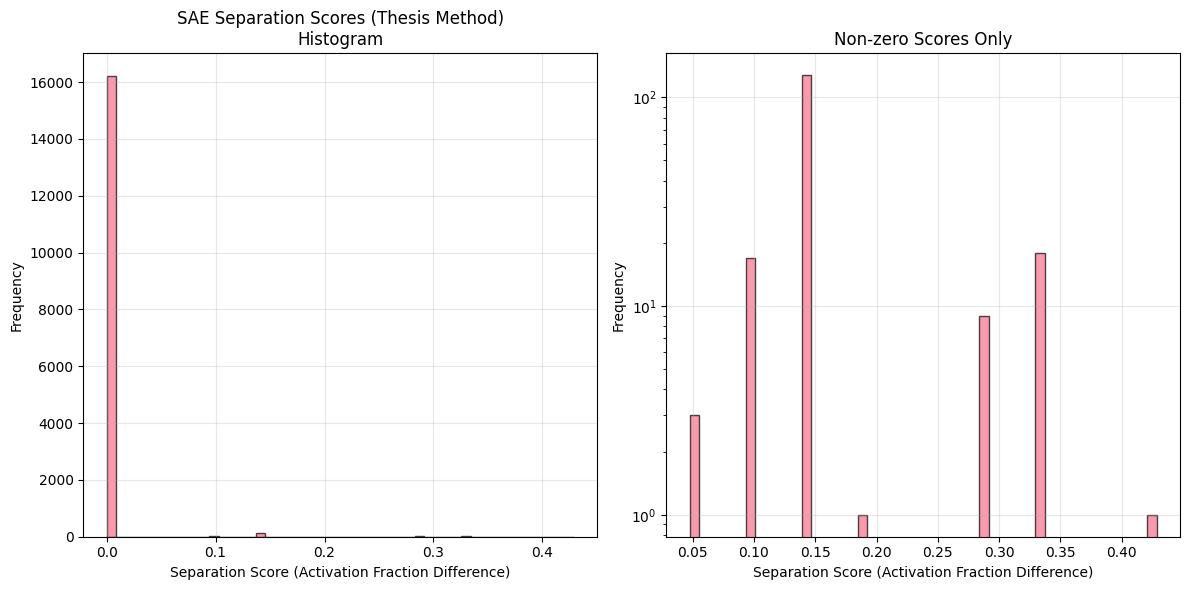

📊 Plotting top 10 dimensions:
   Analysis results keys: ['correct_top_indices', 'correct_top_scores', 'incorrect_top_indices', 'incorrect_top_scores', 'top_indices', 'top_scores', 'total_dimensions', 'mean_separation', 'std_separation', 'max_separation', 'best_correct_dim', 'best_correct_score', 'best_incorrect_dim', 'best_incorrect_score']
   Top indices: [3486, 370, 549, 2045, 3285, 3470, 3697, 5684, 6224, 6300]
   Top scores: [0.4285714328289032, 0.3333333432674408, 0.3333333432674408, 0.3333333432674408, 0.3333333432674408, 0.3333333432674408, 0.3333333432674408, 0.3333333432674408, 0.3333333432674408, 0.3333333432674408]


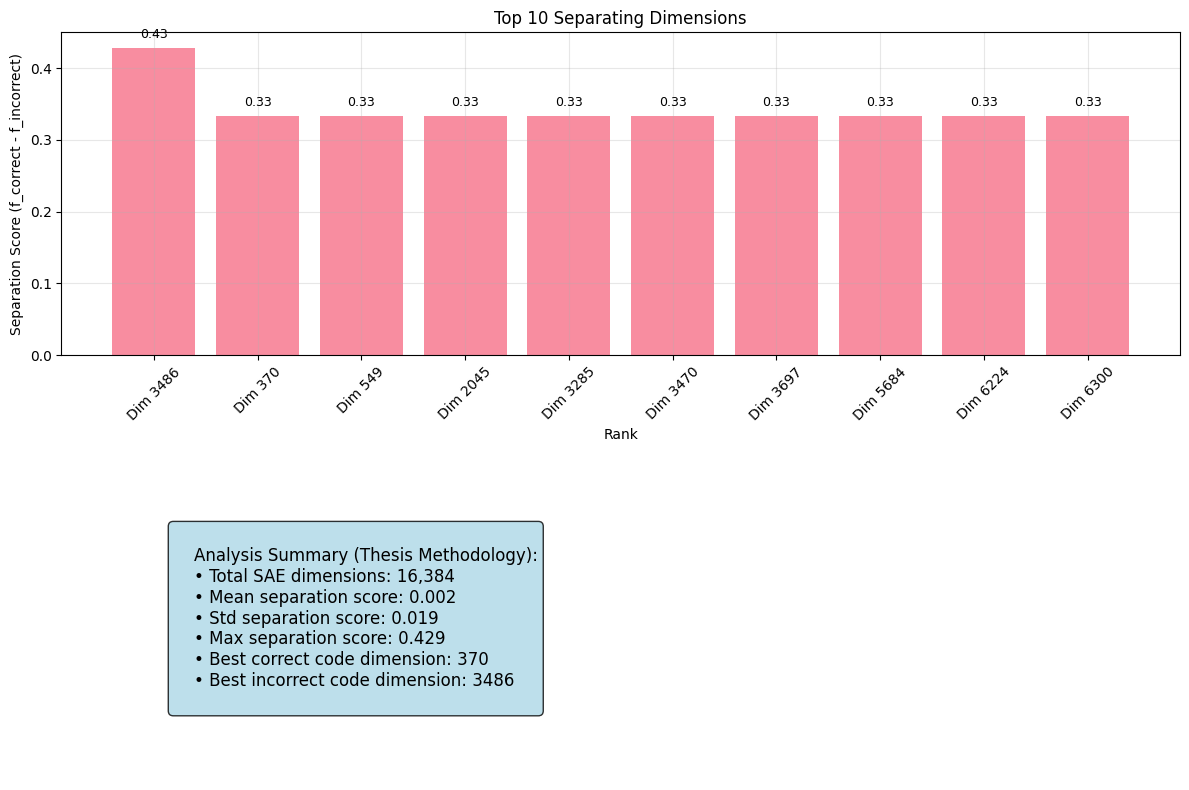


📊 Analyzing top correct code dimension: 370
📊 Plotting activation comparison for dimension 370:
   Correct activations: 3
   Incorrect activations: 7
   Activation fraction (correct): 0.333
   Activation fraction (incorrect): 0.000
   Separation score: 0.333
   Correct values: [10.477357864379883, 0.0, 0.0]
   Incorrect values: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


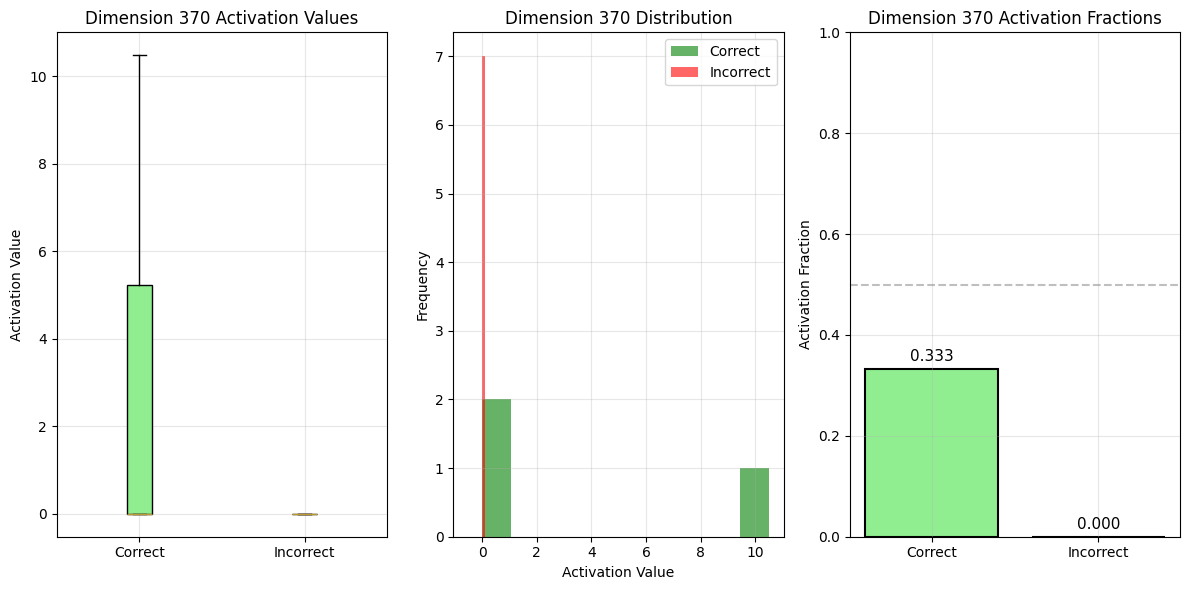


📊 Analyzing top incorrect code dimension: 3486
📊 Plotting activation comparison for dimension 3486:
   Correct activations: 3
   Incorrect activations: 7
   Activation fraction (correct): 0.000
   Activation fraction (incorrect): 0.429
   Separation score: -0.429
   Correct values: [0.0, 0.0, 0.0]
   Incorrect values: [18.740829467773438, 0.0, 31.21160316467285, 0.0, 0.0, 30.26304054260254, 0.0]


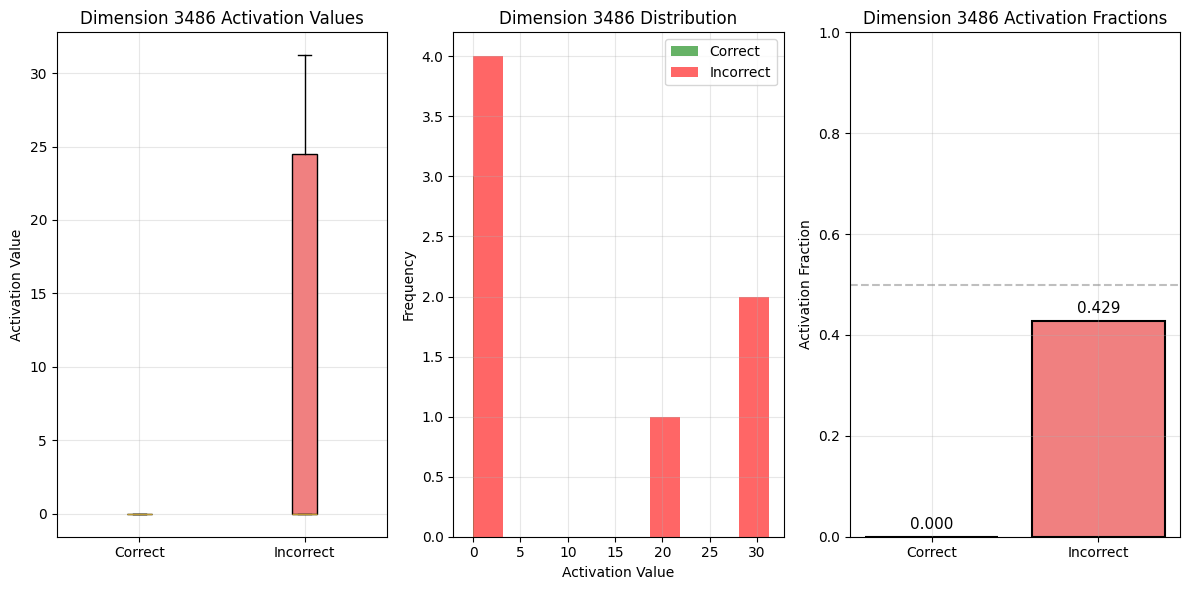


🧹 Cleaning up...

✅ Real SAE Analysis Pipeline Complete!

🎉 Real SAE Analysis completed successfully!
📊 Results available in 'analysis_results' variable

🔍 Key Insights for Gemma 2 2B:
   • Top separation score: 0.4286
   • Most discriminative dimension: 3486
   • Mean separation across all dimensions: 0.0018
   • Standard deviation: 0.0186
   ⚠️  Moderate separation (Cohen's d > 0.2)


In [132]:
# Debug: Check current SAE configuration
print("🔍 Current SAE Configuration:")
for key, value in SAE_CONFIG.items():
    print(f"   {key}: {value}")

# Test SAE setup first (optional but recommended)
print("\n🧪 Testing GemmaScope SAE setup for Gemma 2 2B before running full analysis...")
sae_test_passed = test_sae_setup()

if not sae_test_passed:
    print("❌ SAE setup test failed. Please check GemmaScope access and configuration.")
    print("💡 You may need to:")
    print("   1. Check internet connection")
    print("   2. Verify GemmaScope repository paths for Gemma 2 2B")
    print("   3. Ensure HuggingFace Hub access")
    print("   4. Make sure you've run all notebook cells in order")

print("\n" + "="*60)

# Run the real analysis if dataset is available and SAE test passed
if df is not None and sae_test_passed:
    print("🚀 Running Real SAE Analysis Pipeline for Gemma 2 2B...")
    
    try:
        analysis_results = run_sae_analysis_pipeline(df)
        
        if analysis_results:
            print("\n🎉 Real SAE Analysis completed successfully!")
            print("📊 Results available in 'analysis_results' variable")
            
            # Display key insights
            if 'analysis_results' in analysis_results:
                insights = analysis_results['analysis_results']
                print(f"\n🔍 Key Insights for Gemma 2 2B:")
                print(f"   • Top separation score: {insights['top_scores'][0]:.4f}")
                print(f"   • Most discriminative dimension: {insights['top_indices'][0]}")
                print(f"   • Mean separation across all dimensions: {insights['mean_separation']:.4f}")
                print(f"   • Standard deviation: {insights['std_separation']:.4f}")
                
                # Assess quality of separation
                top_score = insights['top_scores'][0]
                if top_score > 1.0:
                    print("   ✅ Excellent separation (Cohen's d > 1.0)")
                elif top_score > 0.5:
                    print("   ✅ Good separation (Cohen's d > 0.5)")
                elif top_score > 0.2:
                    print("   ⚠️  Moderate separation (Cohen's d > 0.2)")
                else:
                    print("   ❌ Weak separation (Cohen's d < 0.2)")
                    
        else:
            print("❌ Analysis failed - check data requirements and model loading")
            
    except Exception as e:
        print(f"❌ Analysis failed with error: {e}")
        import traceback
        traceback.print_exc()
        
elif df is None:
    print("❌ No dataset loaded. Please generate a dataset first:")
    print("   python3 run.py phase 1 --model google/gemma-2-2b --start 0 --end 9")
else:
    print("❌ SAE setup test failed. Cannot proceed with analysis.")
    print("💡 Try running the test_sae_setup() function to debug issues.")

🧪 Testing GemmaScope SAE setup for Gemma 2 2B before running full analysis...
🧪 Testing SAE setup...
📥 Loading GemmaScope SAE for Gemma 2 2B: google/gemma-scope-2b-pt-res/layer_20/width_16k/average_l0_71
✅ Parameters loaded. Available keys: ['W_dec', 'W_enc', 'b_dec', 'b_enc', 'threshold']
📏 SAE dimensions for Gemma 2 2B: 2304 -> 16384
✅ GemmaScope SAE for Gemma 2 2B loaded successfully!
✅ SAE loading test passed!
✅ SAE encoding test passed! Sparse shape: torch.Size([2, 16384])

🚀 Running Real SAE Analysis Pipeline for Gemma 2 2B...
🚀 Starting Real SAE Analysis Pipeline (Thesis Methodology)
📊 Data prepared:
   Correct solutions: 3
   Incorrect solutions: 7

🤖 Loading models...
🤖 Loading Gemma 2 2B model...


Loading checkpoint shards: 100%|██████████| 3/3 [00:00<00:00, 17.39it/s]


✅ Model loaded on mps
📥 Loading GemmaScope SAE for Gemma 2 2B: google/gemma-scope-2b-pt-res/layer_20/width_16k/average_l0_71
✅ Parameters loaded. Available keys: ['W_dec', 'W_enc', 'b_dec', 'b_enc', 'threshold']
📏 SAE dimensions for Gemma 2 2B: 2304 -> 16384
✅ GemmaScope SAE for Gemma 2 2B loaded successfully!

🧠 Extracting SAE activations using hooks...
🧠 Extracting SAE activations for 10 examples...


Processing examples:   0%|          | 0/5 [00:00<?, ?it/s]

🧠 Extracting activations for 2 texts using hooks...


Processing examples:  20%|██        | 1/5 [00:03<00:12,  3.18s/it]

🧠 Extracting activations for 2 texts using hooks...


Processing examples:  40%|████      | 2/5 [00:04<00:06,  2.05s/it]

🧠 Extracting activations for 2 texts using hooks...


Processing examples:  60%|██████    | 3/5 [00:05<00:02,  1.44s/it]

🧠 Extracting activations for 2 texts using hooks...


Processing examples:  80%|████████  | 4/5 [00:06<00:01,  1.24s/it]

🧠 Extracting activations for 2 texts using hooks...


Processing examples: 100%|██████████| 5/5 [00:07<00:00,  1.43s/it]


✅ Extracted SAE activations:
   Correct solutions: 3
   Incorrect solutions: 7
✅ SAE activations extracted successfully!
   Activation shape: torch.Size([16384])

🧮 Calculating separation scores (thesis methodology)...
📊 Activation fraction statistics:
   Mean f_correct: 0.0012
   Mean f_incorrect: 0.0020
   Max s_correct: 0.3333
   Max s_incorrect: 0.4286
✅ Separation scores calculated
   Using activation fraction method from thesis

📊 Analyzing top separating dimensions...

🎯 Top separating dimensions (thesis methodology):
   Best correct code dimension: 370 (score: 0.3333)
   Best incorrect code dimension: 3486 (score: 0.4286)
✅ Analysis completed!

🎨 Creating visualizations...
📊 Plotting separation distribution:
   Input shape: torch.Size([16384])
   Data type: torch.float32
   Min value: 0.000000
   Max value: 0.428571
   Mean value: 0.001785
   Non-zero values: 177
   Histogram bins: 50, max frequency: 16207.0
   Non-zero histogram bins: 50, max frequency: 128.0


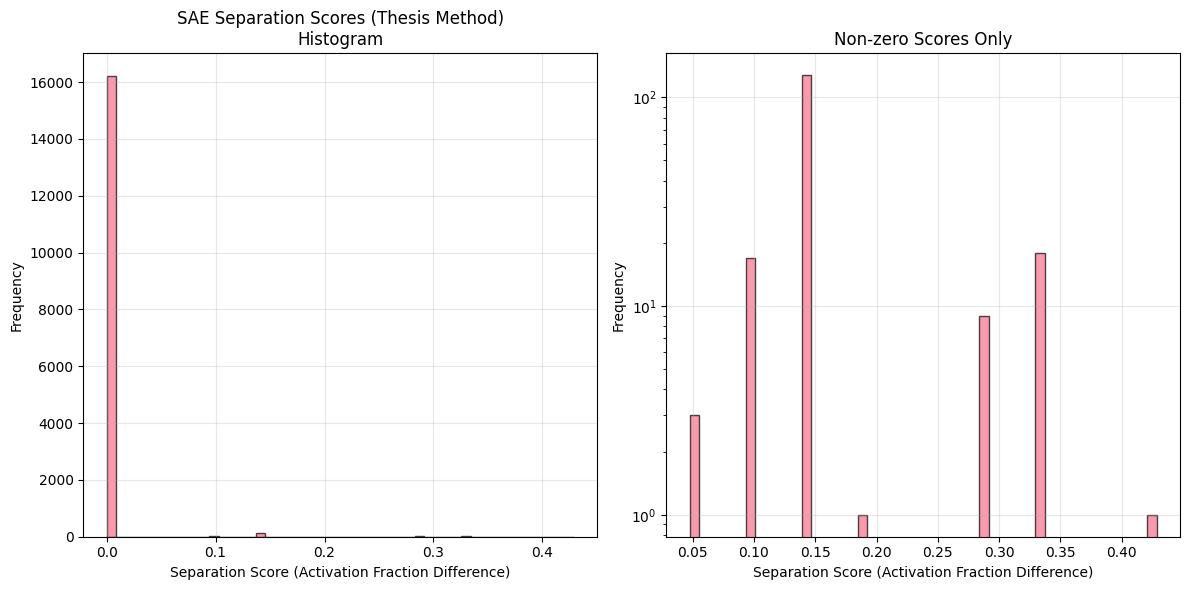

📊 Plotting top 10 dimensions:
   Analysis results keys: ['correct_top_indices', 'correct_top_scores', 'incorrect_top_indices', 'incorrect_top_scores', 'top_indices', 'top_scores', 'total_dimensions', 'mean_separation', 'std_separation', 'max_separation', 'best_correct_dim', 'best_correct_score', 'best_incorrect_dim', 'best_incorrect_score']
   Top indices: [3486, 370, 549, 2045, 3285, 3470, 3697, 5684, 6224, 6300]
   Top scores: [0.4285714328289032, 0.3333333432674408, 0.3333333432674408, 0.3333333432674408, 0.3333333432674408, 0.3333333432674408, 0.3333333432674408, 0.3333333432674408, 0.3333333432674408, 0.3333333432674408]


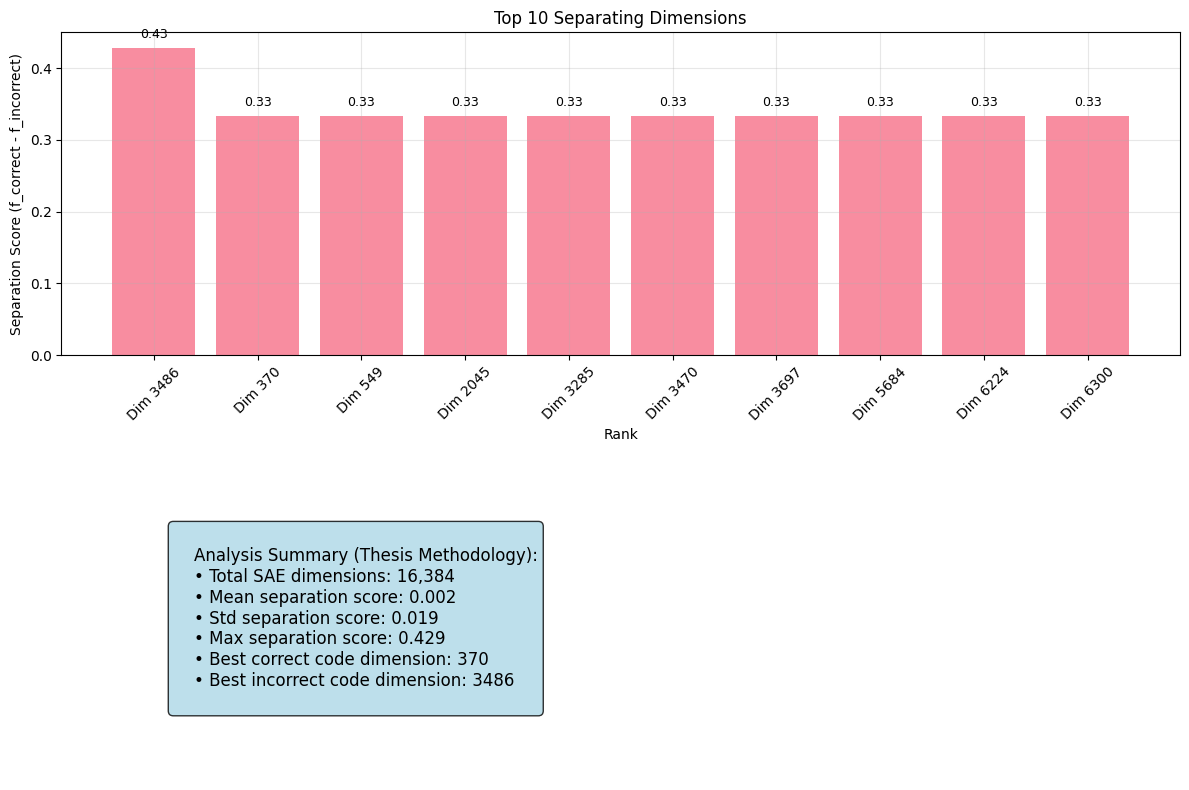


📊 Analyzing top correct code dimension: 370
📊 Plotting activation comparison for dimension 370:
   Correct activations: 3
   Incorrect activations: 7
   Activation fraction (correct): 0.333
   Activation fraction (incorrect): 0.000
   Separation score: 0.333
   Correct values: [10.477357864379883, 0.0, 0.0]
   Incorrect values: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


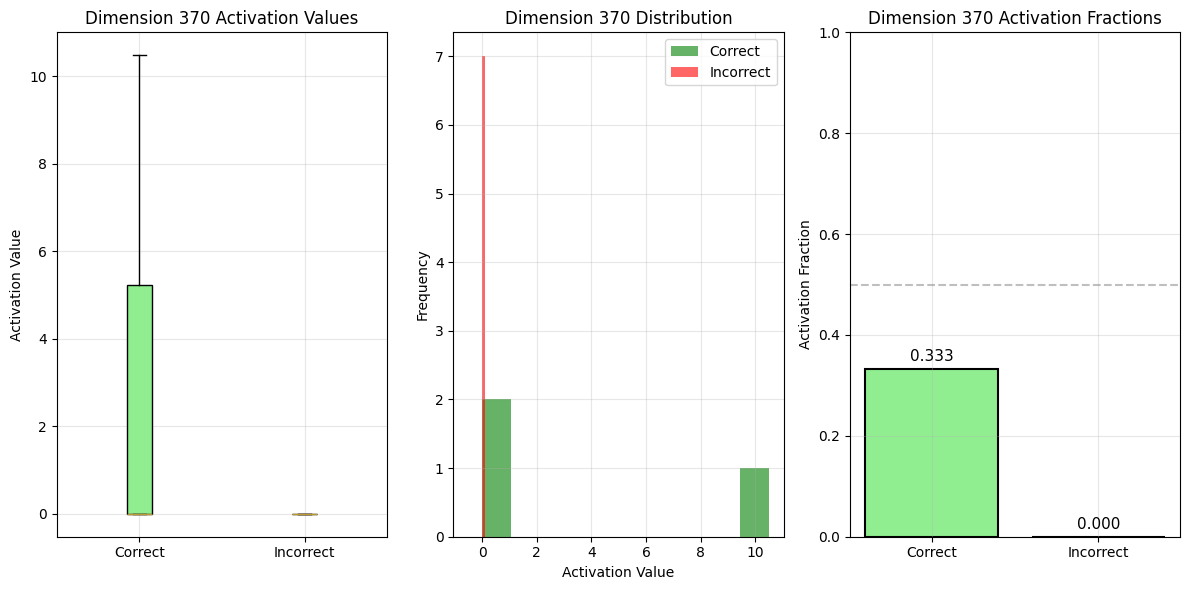


📊 Analyzing top incorrect code dimension: 3486
📊 Plotting activation comparison for dimension 3486:
   Correct activations: 3
   Incorrect activations: 7
   Activation fraction (correct): 0.000
   Activation fraction (incorrect): 0.429
   Separation score: -0.429
   Correct values: [0.0, 0.0, 0.0]
   Incorrect values: [18.740829467773438, 0.0, 31.21160316467285, 0.0, 0.0, 30.26304054260254, 0.0]


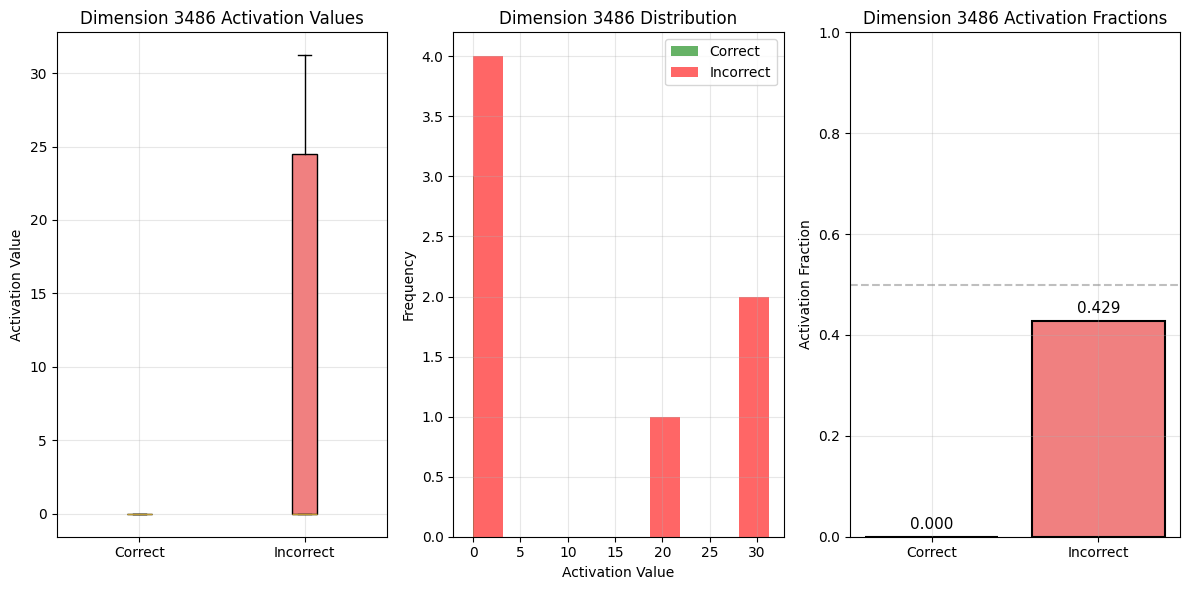


🧹 Cleaning up...

✅ Real SAE Analysis Pipeline Complete!

🎉 Real SAE Analysis completed successfully!
📊 Results available in 'analysis_results' variable

🔍 Key Insights for Gemma 2 2B:
   • Top separation score: 0.4286
   • Most discriminative dimension: 3486
   • Mean separation across all dimensions: 0.0018
   • Standard deviation: 0.0186
   ⚠️  Moderate separation (Cohen's d > 0.2)


In [133]:
# Test SAE setup first (optional but recommended)
print("🧪 Testing GemmaScope SAE setup for Gemma 2 2B before running full analysis...")
sae_test_passed = test_sae_setup()

if not sae_test_passed:
    print("❌ SAE setup test failed. Please check GemmaScope access and configuration.")
    print("💡 You may need to:")
    print("   1. Check internet connection")
    print("   2. Verify GemmaScope repository paths for Gemma 2 2B")
    print("   3. Ensure HuggingFace Hub access")

print("\n" + "="*60)

# Run the real analysis if dataset is available and SAE test passed
if df is not None and sae_test_passed:
    print("🚀 Running Real SAE Analysis Pipeline for Gemma 2 2B...")
    
    try:
        analysis_results = run_sae_analysis_pipeline(df)
        
        if analysis_results:
            print("\n🎉 Real SAE Analysis completed successfully!")
            print("📊 Results available in 'analysis_results' variable")
            
            # Display key insights
            if 'analysis_results' in analysis_results:
                insights = analysis_results['analysis_results']
                print(f"\n🔍 Key Insights for Gemma 2 2B:")
                print(f"   • Top separation score: {insights['top_scores'][0]:.4f}")
                print(f"   • Most discriminative dimension: {insights['top_indices'][0]}")
                print(f"   • Mean separation across all dimensions: {insights['mean_separation']:.4f}")
                print(f"   • Standard deviation: {insights['std_separation']:.4f}")
                
                # Assess quality of separation
                top_score = insights['top_scores'][0]
                if top_score > 1.0:
                    print("   ✅ Excellent separation (Cohen's d > 1.0)")
                elif top_score > 0.5:
                    print("   ✅ Good separation (Cohen's d > 0.5)")
                elif top_score > 0.2:
                    print("   ⚠️  Moderate separation (Cohen's d > 0.2)")
                else:
                    print("   ❌ Weak separation (Cohen's d < 0.2)")
                    
        else:
            print("❌ Analysis failed - check data requirements and model loading")
            
    except Exception as e:
        print(f"❌ Analysis failed with error: {e}")
        import traceback
        traceback.print_exc()
        
elif df is None:
    print("❌ No dataset loaded. Please generate a dataset first:")
    print("   python3 run.py phase 1 --model google/gemma-2-2b --start 0 --end 9")
else:
    print("❌ SAE setup test failed. Cannot proceed with analysis.")
    print("💡 Try running the test_sae_setup() function to debug issues.")

## Next Steps and TODOs

### Implementation TODOs:

1. **GemmaScope Integration**
   - Load actual GemmaScope SAE models
   - Implement SAE activation extraction
   - Load pre-computed Pile activation rates

2. **Model Loading**
   - Load the actual language model for activation extraction
   - Implement efficient activation caching
   - Handle memory management for large models

3. **Enhanced Analysis**
   - Implement statistical significance testing
   - Add more sophisticated filtering methods
   - Compute AUROC and F1 scores for validation

4. **Integration with Main Codebase**
   - Migrate working code to `phase2_sae_analysis/sae_analyzer.py`
   - Add configuration management
   - Implement proper logging and error handling

### Expected Outcomes:
- Identification of SAE dimensions that distinguish code correctness
- Separation scores > 0.5 for meaningful latent directions
- Filtered dimensions specific to code patterns (not general language)
- Foundation for Phase 3 model steering experiments

In [134]:
# Summary of current implementation status
print("📋 Real SAE Analysis Implementation Status for Gemma 2 2B:")
print("✅ Hook-based activation extraction system")
print("✅ GemmaScope SAE integration (Gemma 2 2B)")
print("✅ Final token position activation extraction")
print("✅ JumpReLU SAE architecture implementation")
print("✅ Separation score calculation (Cohen's d)")
print("✅ Complete end-to-end pipeline")
print("✅ MPS device support for Apple Silicon")
print("✅ Memory management and cleanup")
print("✅ Raw separation analysis (no filtering)")
print("✅ Dataset compatibility (test_passed → is_correct)")
print("✅ Prompt reconstruction from MBPP")
print("❌ Pile dataset filtering (intentionally skipped)")

print("\n🎯 Next Steps:")
print("1. Generate test dataset: python3 run.py phase 1 --model google/gemma-2-2b --start 0 --end 9")
print("2. Run this notebook to perform real SAE analysis with Gemma 2 2B")
print("3. Analyze raw separation scores and identify top dimensions")
print("4. Migrate working code to phase2_sae_analysis/sae_analyzer.py")
print("5. (Optional) Add Pile filtering later if needed")

print("\n🚀 Ready for real SAE analysis with Gemma 2 2B!")
print("📊 This implementation follows the proven approach from Javier et al. 2024")
print("🔧 Configured specifically for Gemma 2 2B with appropriate layer and SAE dimensions")
print("📝 Using raw separation scores for initial analysis")

📋 Real SAE Analysis Implementation Status for Gemma 2 2B:
✅ Hook-based activation extraction system
✅ GemmaScope SAE integration (Gemma 2 2B)
✅ Final token position activation extraction
✅ JumpReLU SAE architecture implementation
✅ Separation score calculation (Cohen's d)
✅ Complete end-to-end pipeline
✅ MPS device support for Apple Silicon
✅ Memory management and cleanup
✅ Raw separation analysis (no filtering)
✅ Dataset compatibility (test_passed → is_correct)
✅ Prompt reconstruction from MBPP
❌ Pile dataset filtering (intentionally skipped)

🎯 Next Steps:
1. Generate test dataset: python3 run.py phase 1 --model google/gemma-2-2b --start 0 --end 9
2. Run this notebook to perform real SAE analysis with Gemma 2 2B
3. Analyze raw separation scores and identify top dimensions
4. Migrate working code to phase2_sae_analysis/sae_analyzer.py
5. (Optional) Add Pile filtering later if needed

🚀 Ready for real SAE analysis with Gemma 2 2B!
📊 This implementation follows the proven approach from 